# Data Pre-Processing Report

## Issues:
1. Data Imbalance<br>
        1.1 Example Class 0 has ~22k images while Class 4 has 678 images [huge imbalance]
    
2. Presence of poor quality of images<br>
        2.1 Blurry images<br>
        2.2 Low contrast images<br>
        2.3 Images with low brightness<br>

## Solution tried :
1. Removing blurry images
2. Contrast and Brightness correction
3. Image data aumentation Ex Cropping, Brightness-Contrast change, log transform 
   to increase images in class which has lesser number

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 19.8MB/s 


# Import Data
Creating a directory data_dump where zip files of train and test will be downloaded from kaggle to google drive 
1. Download data using kaggle python package

In [0]:
!mkdir ~/.kaggle
!echo '{"username":"aabhishek","key":"$$$$$$$$$$$$$"}' > ~/.kaggle/kaggle.json
!kaggle competitions download -c diabetic-retinopathy-detection -p data_dump

  0% 0.00/69.4k [00:00<?, ?B/s]
100% 69.4k/69.4k [00:00<00:00, 59.1MB/s]
  0% 0.00/81.6k [00:00<?, ?B/s]
100% 81.6k/81.6k [00:00<00:00, 85.0MB/s]
 48% 5.00M/10.4M [00:00<00:00, 19.5MB/s]
100% 10.4M/10.4M [00:00<00:00, 34.6MB/s]
100% 7.81G/7.81G [00:57<00:00, 110MB/s]
100% 7.81G/7.81G [00:57<00:00, 147MB/s]
100% 7.80G/7.81G [00:56<00:00, 175MB/s]
100% 7.81G/7.81G [00:57<00:00, 147MB/s]
100% 7.80G/7.81G [00:57<00:00, 166MB/s]
100% 7.81G/7.81G [00:57<00:00, 146MB/s]
100% 1.33G/1.34G [00:08<00:00, 175MB/s]
100% 1.34G/1.34G [00:08<00:00, 160MB/s]
100% 7.81G/7.81G [00:57<00:00, 180MB/s]
100% 7.81G/7.81G [00:57<00:00, 146MB/s]
100% 7.81G/7.81G [02:17<00:00, 72.7MB/s]
100% 7.81G/7.81G [02:17<00:00, 60.9MB/s]
100% 7.80G/7.81G [02:15<00:00, 60.1MB/s]
100% 7.81G/7.81G [02:15<00:00, 61.9MB/s]
100% 7.80G/7.81G [02:17<00:00, 82.2MB/s]
100% 7.81G/7.81G [02:17<00:00, 61.0MB/s]
100% 7.80G/7.81G [02:37<00:00, 51.3MB/s]
100% 7.81G/7.81G [02:37<00:00, 53.2MB/s]
100% 7.80G/7.81G [02:25<00:00, 46.5MB/s]
100

#### Using 7zip (by default in google collab) to unzip data

In [0]:
!7z x data_dump/train.zip.001
!unzip data_dump/trainLabels.csv.zip

#### Transfering test and train to tmp folder

In [0]:
!mkdir tmp
!mv train tmp

# Pre-Processing

In [0]:
#importing required libraries
import pandas as pd
import os
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.utils import shuffle
from tqdm import tqdm_notebook
import warnings
from imutils import paths
from PIL import Image
from skimage import io
from skimage import exposure

warnings.filterwarnings('ignore')
%matplotlib inline

#### Head of train label file

In [0]:
trainLabels = pd.read_csv("trainLabels.csv")
trainLabels.head()

image  level
0   10_left      0
1  10_right      0
2   13_left      0
3  13_right      0
4   15_left      1

In [0]:
listing = os.listdir("tmp/train") 

#### Creating different directories for different classes of diabetic eye for classification

In [0]:
!mkdir tmp/train/0
!mkdir tmp/train/1
!mkdir tmp/train/2
!mkdir tmp/train/3
!mkdir tmp/train/4


#### Using trainLabels file to segregrate into different classes

In [ ]:
base_dir = "tmp/train/"

for file in listing:
    try:
        fileName = os.path.splitext(file)[0]
        folder_name = trainLabels.loc[trainLabels.image==fileName, 'level'].values[0]  
        os.rename(base_dir + file, base_dir + str(folder_name) + "/" + file )
    except:
        print("error")
        pass

#### For verification checking files in class 0 ~ 25,810 images

In [0]:
!ls tmp/train/0 | wc -l

25810


### Variance Of Laplacian

Laplacian of image gives edges present in an image. Blurry images have less edges so variance of edges will be lesser than as compared to sharp images. Thus a well focused image is expected to have a high variation in grey levels.

[1] R. Bansal, G. Raj and T. Choudhury, "Blur image detection using Laplacian operator and Open-CV," 2016 International Conference System Modeling & Advancement in Research Trends (SMART), Moradabad, 2016, pp. 63-67.

In [0]:
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

In [0]:
def blur_check(PATH): 
    image_dict = {}
    list_of_images = os.listdir(PATH)
    for im in list_of_images:
        image = cv2.imread(PATH+im)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        fm = variance_of_laplacian(gray)
        #plt.imshow(image);
        #plt.show()
        image_dict[im]= fm 
    return image_dict

#### Function for image resizing and overwriting existing image

In [ ]:
def resize(PATH):
    images = os.listdir(PATH);
    for image in images:
        name = PATH + image
        im = cv2.imread(name)
        im = cv2.resize (im, (512, 512));
        cv2.imwrite(name, im)

#### Function for deleting blurry image, delete path to be supplied

In [ ]:
def remove_blur_images(BASE_DIR,to_delete):
    for file in to_delete:
        os.remove(BASE_DIR+file)

### Data Augmentation
#### 1. Contrast Enhancement - change the image intensity value distribution to cover a wide range

#### 2. Log Enhancement - The dynamic range of an image can be compressed by replacing each pixel value with its logarithm. This      has the effect that low intensity pixel values are enhanced. Applying a pixel logarithm operator to an image can be useful in applications where the dynamic range may too large to be displayed on a screen (or to be recorded on a film in the first place)
[2] R. Gonzalez and R. Woods Digital Image Processing, Addison-Wesley Publishing Company, 1992, pp 167 - 168.

#### 3. Sigmoid Correction - Similar to contrast enhancement 
[3] Saruchi. “Adaptive Sigmoid Function to Enhance Low Contrast Images.” (2012)

In [ ]:
def data_aug_val(path):
    listing_test = os.listdir(path)
    for file_name in listing_test:
            image = io.imread(path+file_name)
            v_min, v_max = np.percentile(image, (0.2, 99.8))
            better_contrast = exposure.rescale_intensity(image, in_range=(v_min, v_max))
            log_correction_image = exposure.adjust_log(image)
            sigmoid_correction_image = exposure.adjust_sigmoid(image)
            horizontal_flip = image[:, ::-1]
            #color_inversion_image_with_np = np.invert(image)
            #adjusted_gamma_image = exposure.adjust_gamma(image, gamma=0.4, gain=0.9)
            io.imsave(path+str(1)+file_name,better_contrast)
            io.imsave(path+str(2)+file_name,log_correction_image)
            io.imsave(path+str(3)+file_name,sigmoid_correction_image)

In [ ]:
#Function for removing excess image
def remove_excess_images(PATH,number):
    listing = os.listdir(PATH) 
    to_delete = random.sample(listing, number)
    for file in to_delete:
        os.remove(PATH+file)

In [ ]:
#Similar to data_aug_val but for testing purpose
def data_aug_val_1(path):
    listing_test = os.listdir(path)
    for file_name in listing_test:
            image = io.imread(path+file_name)
            log_correction_image = exposure.adjust_log(image)
            #color_inversion_image_with_np = np.invert(image)
            #adjusted_gamma_image = exposure.adjust_gamma(image, gamma=0.4, gain=0.9)
            #io.imsave(path+str(1)+file_name,better_contrast)
            io.imsave(path+str(2)+file_name,log_correction_image)
            #io.imsave(path+str(3)+file_name,sigmoid_correction_image)

In [0]:
# Calling for image resize
%time resize("tmp/train/0/")
%time resize("tmp/train/1/")
%time resize("tmp/train/2/")
%time resize("tmp/train/3/")
%time resize("tmp/train/4/")

CPU times: user 39min 41s, sys: 1min 44s, total: 41min 26s
Wall time: 40min 25s
CPU times: user 39min 41s, sys: 1min 44s, total: 41min 26s
Wall time: 40min 25s
CPU times: user 3min 43s, sys: 10.1 s, total: 3min 53s
Wall time: 3min 47s
CPU times: user 3min 43s, sys: 10.1 s, total: 3min 53s
Wall time: 3min 47s
CPU times: user 8min 25s, sys: 22.6 s, total: 8min 47s
Wall time: 8min 34s
CPU times: user 8min 25s, sys: 22.6 s, total: 8min 47s
Wall time: 8min 34s
CPU times: user 1min 24s, sys: 3.61 s, total: 1min 28s
Wall time: 1min 26s
CPU times: user 1min 24s, sys: 3.61 s, total: 1min 28s
Wall time: 1min 26s
CPU times: user 1min 9s, sys: 2.96 s, total: 1min 12s
Wall time: 1min 10s
CPU times: user 1min 9s, sys: 2.96 s, total: 1min 12s
Wall time: 1min 10s


#### Checking bluriiness of the images and dropping 10% of the total images as they are most blurred

In [0]:
%time dict_sharp = blur_check("./tmp/train/0/")

CPU times: user 3min 34s, sys: 25.3 s, total: 4min
Wall time: 3min 34s
CPU times: user 3min 34s, sys: 25.3 s, total: 4min
Wall time: 3min 34s


In [0]:
#creating a dataframe of val and image name 
val_series = pd.Series(dict_sharp)
df = pd.DataFrame(val_series,columns=["val"])
df.sort_values(by='val',inplace=True)
df.reset_index(level=0, inplace=True)

In [0]:
df.head(3000).tail(10)

index        val
2990   23233_left.jpeg  29.951339
2991   13042_left.jpeg  29.955024
2992  38243_right.jpeg  29.963623
2993   41312_left.jpeg  29.971027
2994   20316_left.jpeg  29.976616
2995  13196_right.jpeg  29.979807
2996   33159_left.jpeg  29.982596
2997   38162_left.jpeg  29.989548
2998  43225_right.jpeg  29.992973
2999  14933_right.jpeg  29.996082

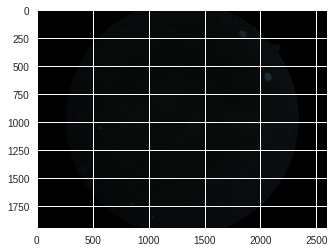

In [0]:
#checking the image having the lowest val
image = cv2.imread("./tmp/train/0/27481_right.jpeg")
plt.imshow(image);
plt.show()

In [0]:
to_delete = df["index"].head(3000).tolist()
remove_blur_images("./tmp/train/0/",to_delete)

#### Dropped blurred images from class 0

In [0]:
!ls tmp/train/0 | wc -l

22810


In [0]:
%time dict_sharp = blur_check("./tmp/train/1/")
frame = pd.Series(dict_sharp)
df = pd.DataFrame(frame,columns=["val"])
df.sort_values(by='val',inplace=True)
df.reset_index(level=0, inplace=True)

CPU times: user 20.3 s, sys: 3.23 s, total: 23.6 s
Wall time: 21.1 s


In [0]:
df.head(100).tail()

index        val
95  13043_right.jpeg  23.295280
96   30205_left.jpeg  23.316267
97    393_right.jpeg  23.355272
98  41105_right.jpeg  23.369600
99   39832_left.jpeg  23.531645

In [0]:
to_delete = df["index"].head(100).tolist()
remove_blur_images("./tmp/train/1/",to_delete)

In [0]:
!ls tmp/train/1 | wc -l

2343


In [0]:
%time dict_sharp = blur_check("./tmp/train/2/")
frame = pd.Series(dict_sharp)
df = pd.DataFrame(frame,columns=["val"])
df.sort_values(by='val',inplace=True)
df.reset_index(level=0, inplace=True)

CPU times: user 43.5 s, sys: 6.05 s, total: 49.5 s
Wall time: 43.2 s


In [0]:
df.head(250).tail()

index        val
245  21447_right.jpeg  18.958998
246  33746_right.jpeg  18.960989
247   30069_left.jpeg  18.976494
248   9942_right.jpeg  18.976888
249    2357_left.jpeg  19.053912

In [0]:
to_delete = df["index"].head(250).tolist()
remove_blur_images("./tmp/train/2/",to_delete)

In [0]:
%time dict_sharp = blur_check("./tmp/train/3/")

CPU times: user 7.25 s, sys: 983 ms, total: 8.23 s
Wall time: 7.19 s


In [0]:
frame = pd.Series(dict_sharp)
df = pd.DataFrame(frame,columns=["val"])
df.sort_values(by='val',inplace=True)
df.reset_index(level=0, inplace=True)

In [0]:
df.head(40).tail()

index        val
35    8699_left.jpeg  16.152079
36   40259_left.jpeg  17.012925
37   5298_right.jpeg  17.035852
38   18971_left.jpeg  17.069210
39  34006_right.jpeg  17.433434

In [0]:
to_delete = df["index"].head(40).tolist()
remove_blur_images("./tmp/train/3/",to_delete)

In [0]:
%time dict_sharp = blur_check("./tmp/train/4/")

CPU times: user 5.92 s, sys: 776 ms, total: 6.69 s
Wall time: 5.84 s


In [0]:
frame = pd.Series(dict_sharp)
df = pd.DataFrame(frame,columns=["val"])
df.sort_values(by='val',inplace=True)
df.reset_index(level=0, inplace=True)

In [0]:
df.head(30)

index        val
0    30723_left.jpeg   4.110168
1    40178_left.jpeg   5.632523
2    30675_left.jpeg   7.969081
3    6613_right.jpeg   8.131547
4   41852_right.jpeg   8.718414
5   17411_right.jpeg   9.154816
6    35704_left.jpeg   9.200000
7   31659_right.jpeg   9.372860
8    40819_left.jpeg  10.066191
9    9298_right.jpeg  10.068080
10    6613_left.jpeg  10.081295
11  36300_right.jpeg  10.214231
12   42316_left.jpeg  10.336052
13   5258_right.jpeg  10.546245
14  23648_right.jpeg  10.660364
15   42484_left.jpeg  10.778426
16  40819_right.jpeg  11.090302
17  40323_right.jpeg  11.342355
18    5258_left.jpeg  11.785373
19  21788_right.jpeg  11.791588
20   22716_left.jpeg  11.906851
21   37008_left.jpeg  12.160895
22   31659_left.jpeg  13.033192
23   39505_left.jpeg  13.103392
24  22716_right.jpeg  13.159921
25  16802_right.jpeg  13.668926
26   2804_right.jpeg  13.702373
27   21788_left.jpeg  14.047569
28    9298_left.jpeg  14.245277
29    8681_left.jpeg  14.351860

In [0]:
to_delete = df["index"].head(30).tolist()
remove_blur_images("./tmp/train/4/",to_delete)

In [0]:
!ls tmp/train/0 | wc -l

22810


In [0]:
!ls tmp/train/1 | wc -l

2343


In [0]:
!ls tmp/train/2 | wc -l

5042


In [0]:
!ls tmp/train/3 | wc -l

833


In [0]:
!ls tmp/train/4 | wc -l

678


### Data imbalance problem is there, which will affect classification
![title](imjup/data_dist.jpeg)

In [0]:
remove_excess_images("tmp/train/0/",14000)

In [0]:
!ls tmp/train/0 | wc -l

8810


### Data Distribution after removing excess images which can be taken as undersampling as well based on the defined criteria above

![title](imjup/data_dist_1.jpeg)

In [0]:
data_aug_val_1("tmp/train/1/")

In [0]:
data_aug_val("tmp/train/3/")
data_aug_val("tmp/train/4/")

### Data Distribution after augmentation
![title](imjup/data_dist_2.jpeg)

#### Data imbalance has been considerably reduced now

In [ ]:
#creating a zip file containing all the train images
#using capture to mute the outputs
%%capture
!zip -r tmp/train{.zip,}

### Saving Images in google Drive

In [0]:
#uploading the zip created

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


# 2. Save Keras Model or weights on google drive

# create on Colab directory
  
model_file = drive.CreateFile({'title' : 'train.zip'})
model_file.SetContentFile('./tmp/train.zip')
model_file.Upload()

# download to google drive
drive.CreateFile({'id': model_file.get('id')})


GoogleDriveFile({'id': '12pmf7HcIoXtDNw7jXwUnqv6eXAG-zkjA'})